# Task 3 – Visualisation Portfolio

Academic-ready figures (white theme) and interactive dashboard assets are produced in tandem. Interpretive notes for the report are kept in `reports/notes/task3_visualization.txt`.

## Styling setup

In [1]:

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

ROOT = Path('..')
DATA_PATH = ROOT / 'data' / 'raw' / 'train_252145.csv'
FIGURES_DIR = ROOT / 'reports' / 'figures'
INTERACTIVE_DIR = FIGURES_DIR / 'interactive'
TABLES_DIR = ROOT / 'reports' / 'tables'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
INTERACTIVE_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

COLORS = {
    'pv': '#FFA500',        # solar orange
    'demand': '#2ca02c',    # battery green
    'price': '#1f77b4',     # grid blue
    'storage': '#7f7f7f',   # neutral gray
}

mpl.rcParams.update({
    'figure.dpi': 110,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'semibold',
    'axes.titlelocation': 'left',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': '#d9d9d9',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,
    'axes.grid': True,
    'font.family': 'DejaVu Sans',
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '#dddddd',
})

sns.set_theme(style='whitegrid')

COLORWAY = [COLORS['pv'], COLORS['demand'], COLORS['price'], COLORS['storage']]
pio.templates['energy_light'] = go.layout.Template(layout=dict(
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(family='Inter, Open Sans, sans-serif', color='#212529'),
    colorway=COLORWAY,
    xaxis=dict(gridcolor='#e9ecef', zerolinecolor='#e9ecef'),
    yaxis=dict(gridcolor='#e9ecef', zerolinecolor='#e9ecef'),
    legend=dict(bgcolor='rgba(255,255,255,0.85)', bordercolor='#ced4da', borderwidth=1),
    hoverlabel=dict(bgcolor='#f8f9fa', font=dict(color='#212529')),
))
pio.templates.default = 'energy_light'
px.defaults.template = 'energy_light'
px.defaults.color_discrete_sequence = COLORWAY


def save_figure(fig, basename, dpi=300):
    png_path = FIGURES_DIR / f'{basename}.png'
    pdf_path = FIGURES_DIR / f'{basename}.pdf'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    fig.savefig(pdf_path, dpi=dpi, bbox_inches='tight')
    return png_path, pdf_path


def save_interactive(fig, basename):
    html_path = INTERACTIVE_DIR / f'{basename}.html'
    fig.write_html(html_path, include_plotlyjs='cdn')
    return html_path


## Load and enrich the dataset

In [2]:

df = pd.read_csv(DATA_PATH, parse_dates=['timestamp']).sort_values('timestamp')
df = df.set_index('timestamp')
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_name()
df['is_weekend'] = df.index.dayofweek >= 5
df.head()


,pv_mod1,pv_mod2,pv_mod3,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),...,Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),daymax,hour,day_of_week,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4,0,...,3,10.5,NaN,0,0,0.0,3.56,0,Monday,False
2013-07-01 01:00:00+00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27,1,...,23,11.9,NaN,0,0,0.0,3.56,1,Monday,False
2013-07-01 02:00:00+00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33,0,...,32,11.6,NaN,0,0,0.0,3.56,2,Monday,False
2013-07-01 03:00:00+00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28,0,...,27,11.2,NaN,2,7,30.1,3.56,3,Monday,False
2013-07-01 04:00:00+00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16,0,...,14,11.7,NaN,30,31,252.0,3.56,4,Monday,False


In [3]:

summary = df[['pv', 'Demand', 'Price']].describe().T.round(3)
summary_path = TABLES_DIR / 'task3_summary_stats.csv'
summary.to_csv(summary_path)
summary


,count,mean,std,min,25%,50%,75%,max
pv,8759.0,0.660,1.106,0.0,0.000,0.000,0.82,4.810
Demand,8759.0,0.531,0.375,0.0,0.280,0.380,0.66,4.240
Price,8759.0,0.046,0.025,0.0,0.028,0.045,0.06,0.255


## Figure 1 – Timeseries overlay

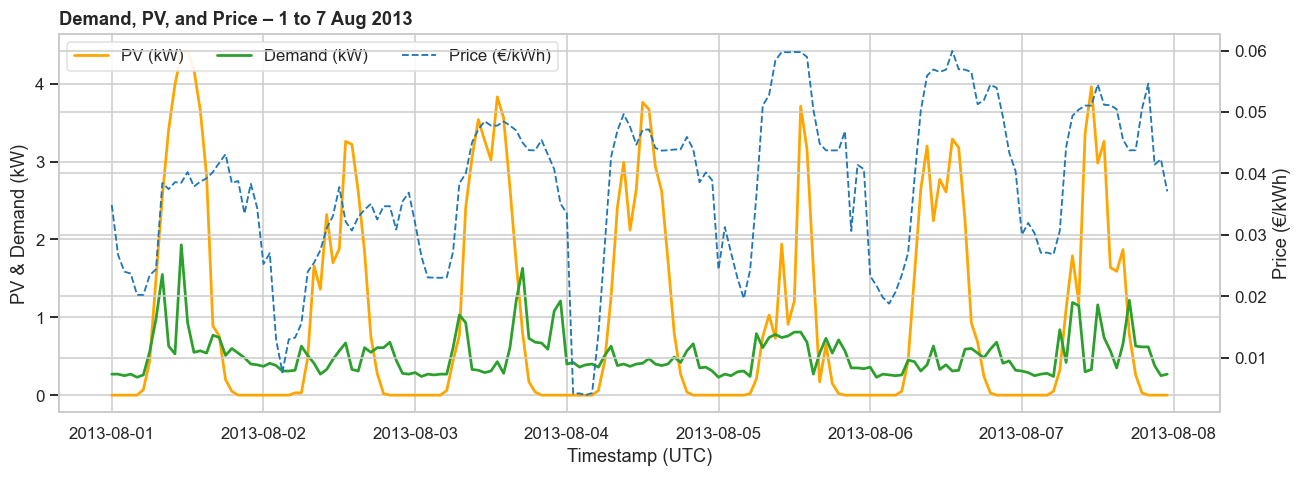

In [4]:

week_window = df.loc['2013-08-01':'2013-08-07']
fig, ax_left = plt.subplots(figsize=(12, 4.5))
ax_right = ax_left.twinx()
ax_left.plot(week_window.index, week_window['pv'], color=COLORS['pv'], linewidth=1.8, label='PV (kW)')
ax_left.plot(week_window.index, week_window['Demand'], color=COLORS['demand'], linewidth=1.8, label='Demand (kW)')
ax_right.plot(week_window.index, week_window['Price'], color=COLORS['price'], linewidth=1.2, linestyle='--', label='Price (€/kWh)')
ax_left.set_title('Demand, PV, and Price – 1 to 7 Aug 2013')
ax_left.set_ylabel('PV & Demand (kW)')
ax_right.set_ylabel('Price (€/kWh)')
ax_left.set_xlabel('Timestamp (UTC)')
lines, labels = ax_left.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax_left.legend(lines + lines2, labels + labels2, loc='upper left', ncol=3)
fig.tight_layout()
save_figure(fig, 'task3_fig1_timeseries_overlay')
plt.show()

interactive_fig = go.Figure()
interactive_fig.add_trace(go.Scatter(x=week_window.index, y=week_window['pv'], name='PV (kW)', mode='lines'))
interactive_fig.add_trace(go.Scatter(x=week_window.index, y=week_window['Demand'], name='Demand (kW)', mode='lines'))
interactive_fig.add_trace(go.Scatter(x=week_window.index, y=week_window['Price'], name='Price (€/kWh)', mode='lines', yaxis='y2', line=dict(dash='dash')))
interactive_fig.update_layout(
    title='Demand, PV, and Price – 1 to 7 Aug 2013',
    xaxis_title='Timestamp (UTC)',
    yaxis=dict(title='PV & Demand (kW)'),
    yaxis2=dict(title='Price (€/kWh)', overlaying='y', side='right'),
)
save_interactive(interactive_fig, 'task3_fig1_timeseries_overlay_interactive')
interactive_fig.show()


**Figure 1.** PV, demand, and price dynamics during the first week of August 2013; evening demand peaks appear after solar output subsides.

## Figure 2 – Demand and PV distributions

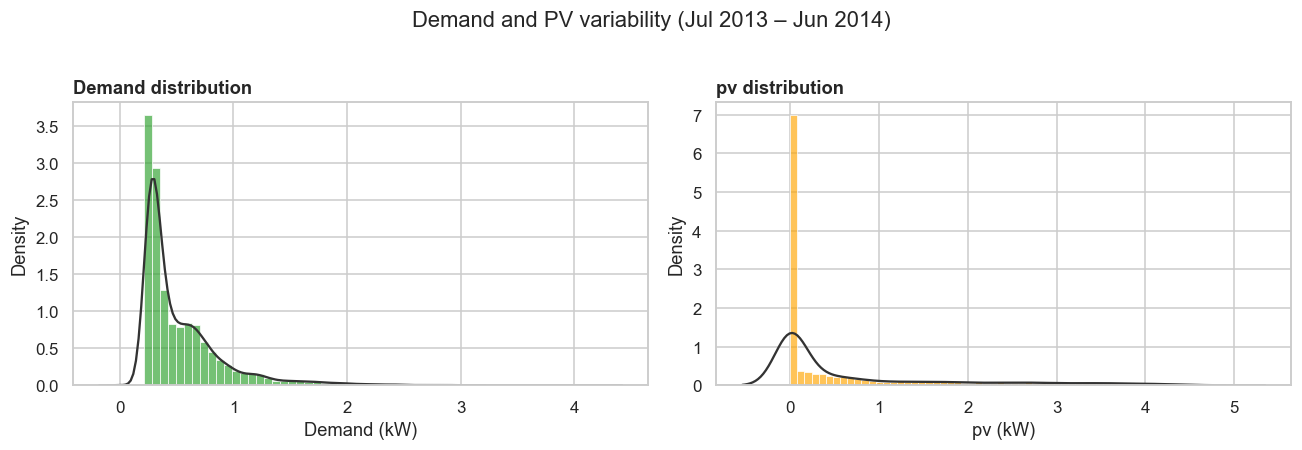

In [5]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, column, color in zip(axes, ['Demand', 'pv'], [COLORS['demand'], COLORS['pv']]):
    sns.histplot(df[column], bins=60, stat='density', color=color, alpha=0.65, edgecolor='white', ax=ax)
    sns.kdeplot(df[column], color='#333333', linewidth=1.5, ax=ax)
    ax.set_title(f'{column} distribution')
    ax.set_xlabel(f'{column} (kW)')
    ax.set_ylabel('Density')
fig.suptitle('Demand and PV variability (Jul 2013 – Jun 2014)', y=1.02)
fig.tight_layout()
save_figure(fig, 'task3_fig2_distributions')
plt.show()

interactive_fig = go.Figure()
interactive_fig.add_trace(go.Histogram(x=df['Demand'], name='Demand (kW)', nbinsx=60, histnorm='probability density', opacity=0.6, marker_color=COLORS['demand']))
interactive_fig.add_trace(go.Histogram(x=df['pv'], name='PV (kW)', nbinsx=60, histnorm='probability density', opacity=0.6, marker_color=COLORS['pv']))
interactive_fig.update_layout(barmode='overlay', title='Demand and PV distributions', xaxis_title='Value (kW)', yaxis_title='Density')
save_interactive(interactive_fig, 'task3_fig2_distributions_interactive')
interactive_fig.show()


**Figure 2.** Histograms with KDE overlays showing typical operating ranges and skewness for demand and PV output.

## Figure 3 – Hourly demand boxplots

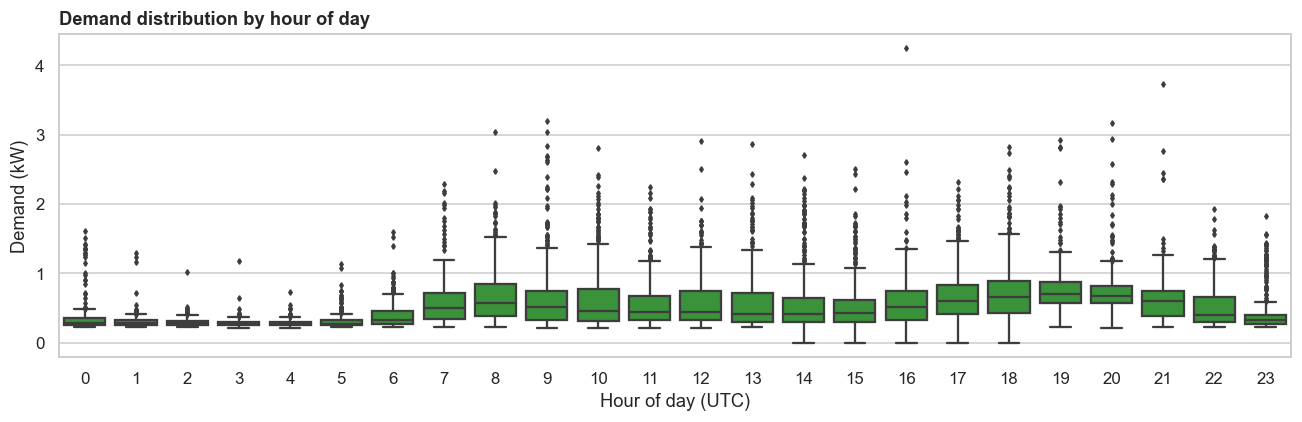

In [6]:

fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=df, x='hour', y='Demand', color=COLORS['demand'], ax=ax, fliersize=2.5)
ax.set_title('Demand distribution by hour of day')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('Demand (kW)')
fig.tight_layout()
save_figure(fig, 'task3_fig3_hourly_boxplot')
plt.show()

interactive_fig = px.box(df, x='hour', y='Demand', color_discrete_sequence=[COLORS['demand']])
interactive_fig.update_layout(title='Demand distribution by hour of day', xaxis_title='Hour of day (UTC)', yaxis_title='Demand (kW)')
save_interactive(interactive_fig, 'task3_fig3_hourly_boxplot_interactive')
interactive_fig.show()


**Figure 3.** Hourly boxplots highlighting evening peaks and variability important for storage dispatch.

## Figure 4 – Correlation heatmap

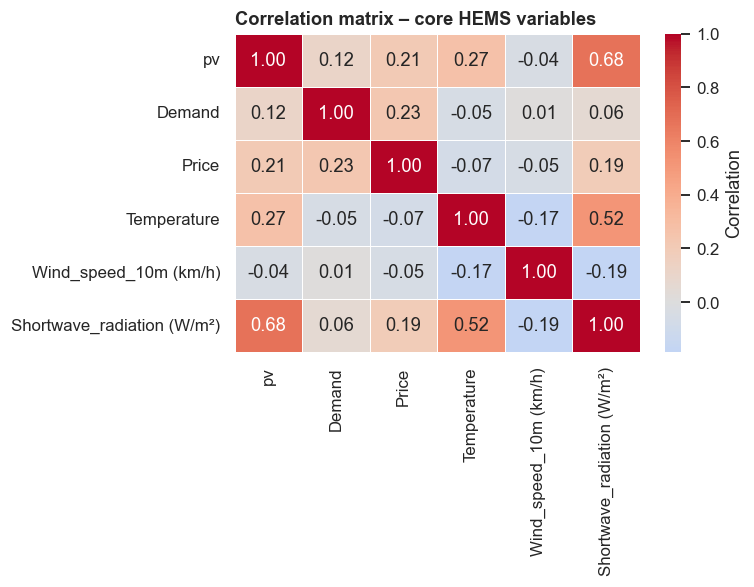

In [7]:

corr_cols = ['pv', 'Demand', 'Price', 'Temperature', 'Wind_speed_10m (km/h)', 'Shortwave_radiation (W/m²)']
correlation = df[corr_cols].corr()
fig, ax = plt.subplots(figsize=(7, 5.5))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Correlation matrix – core HEMS variables')
fig.tight_layout()
save_figure(fig, 'task3_fig4_correlation_heatmap')
plt.show()

interactive_fig = go.Figure(data=go.Heatmap(z=correlation.values, x=corr_cols, y=corr_cols, colorscale='RdBu', zmin=-1, zmax=1, colorbar=dict(title='ρ')))
interactive_fig.update_layout(title='Correlation matrix – core HEMS variables')
save_interactive(interactive_fig, 'task3_fig4_correlation_heatmap_interactive')
interactive_fig.show()


**Figure 4.** Correlations between load, generation, price, and weather drivers used to guide feature engineering.

## Figure 5 – Typical daily profiles

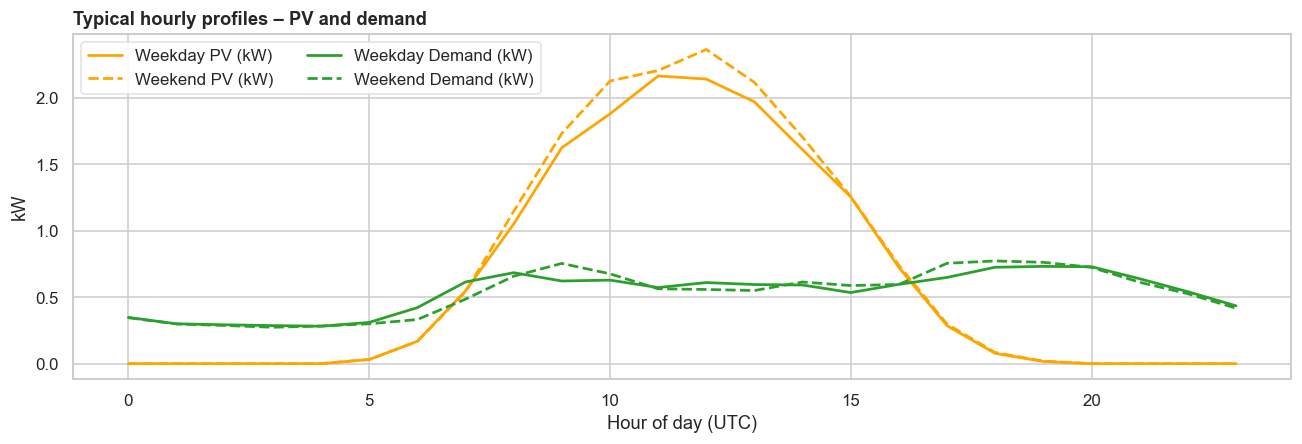

In [8]:

profile = df.groupby(['is_weekend', 'hour'])[['pv', 'Demand']].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 4.2))
weekday = profile[profile['is_weekend'] == False]
weekend = profile[profile['is_weekend'] == True]
ax.plot(weekday['hour'], weekday['pv'], color=COLORS['pv'], linewidth=1.8, label='Weekday PV (kW)')
ax.plot(weekend['hour'], weekend['pv'], color=COLORS['pv'], linestyle='--', linewidth=1.8, label='Weekend PV (kW)')
ax.plot(weekday['hour'], weekday['Demand'], color=COLORS['demand'], linewidth=1.8, label='Weekday Demand (kW)')
ax.plot(weekend['hour'], weekend['Demand'], color=COLORS['demand'], linestyle='--', linewidth=1.8, label='Weekend Demand (kW)')
ax.set_title('Typical hourly profiles – PV and demand')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('kW')
ax.legend(ncol=2, loc='upper left')
fig.tight_layout()
save_figure(fig, 'task3_fig5_typical_profiles')
plt.show()

interactive_fig = go.Figure()
interactive_fig.add_trace(go.Scatter(x=weekday['hour'], y=weekday['pv'], name='Weekday PV (kW)', mode='lines'))
interactive_fig.add_trace(go.Scatter(x=weekend['hour'], y=weekend['pv'], name='Weekend PV (kW)', mode='lines', line=dict(dash='dash')))
interactive_fig.add_trace(go.Scatter(x=weekday['hour'], y=weekday['Demand'], name='Weekday Demand (kW)', mode='lines'))
interactive_fig.add_trace(go.Scatter(x=weekend['hour'], y=weekend['Demand'], name='Weekend Demand (kW)', mode='lines', line=dict(dash='dash')))
interactive_fig.update_layout(title='Typical hourly profiles – PV and demand', xaxis_title='Hour of day (UTC)', yaxis_title='kW')
save_interactive(interactive_fig, 'task3_fig5_typical_profiles_interactive')
interactive_fig.show()


**Figure 5.** Weekday versus weekend profiles clarifying when storage and flexible loads must bridge the PV-demand mismatch.

## Reflection
The typical hourly profiles (Figure 5) are the most informative for HEMS decisions because they expose when demand reliably exceeds solar supply, quantify how behaviour shifts on weekends, and therefore directly inform storage charging/discharging strategies aimed at maximising self-consumption and minimising grid imports.